In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [43]:
def plot_series(time,series,format='-',start=0, end=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end],series_num[start:end],format)
    else:
        plt.plot(time[start:end],series[start:end],format)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

def trend(time,slope=0):
    series=slope*time
    return series

def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))
    return data_pattern

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time,noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise


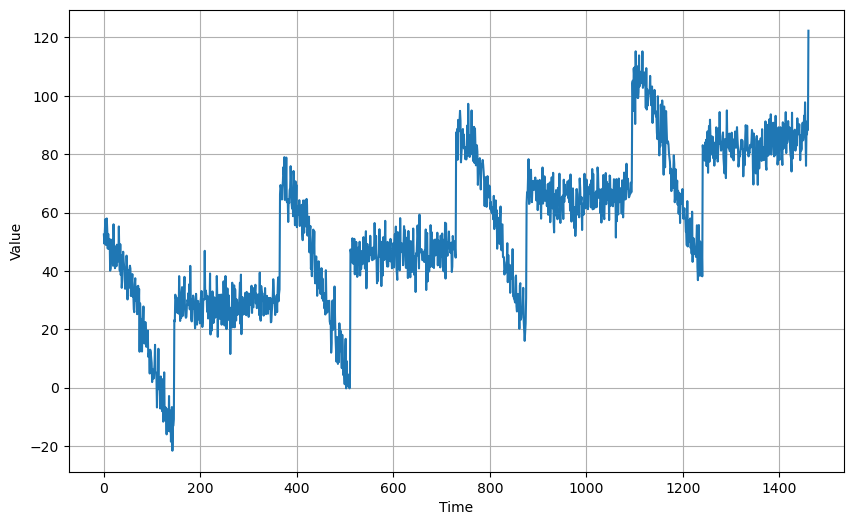

In [44]:
time=np.arange(4*365+1,dtype='float32')
baseline=10
amplitude=40
slope=0.05
noise_level=5

series=baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
series+=noise(time,noise_level,seed=42)
plot_series(time,series)

In [45]:
split_time=1000
time_train=time[:split_time]
x_train=series[:split_time]
time_valid=time[split_time:]
x_valid=series[split_time:]

In [46]:
window_size=20
batch_size=32
shuffle_buffer_size=1000

In [47]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    datasets=tf.data.Dataset.from_tensor_slices(series)
    datasets=datasets.window(window_size+1,shift=1,drop_remainder=True)
    datasets=datasets.flat_map(lambda window:window.batch(window_size+1))
    datasets=datasets.map(lambda window:(window[:-1],window[-1]))
    datasets=datasets.shuffle(shuffle_buffer)
    datasets=datasets.batch(batch_size).prefetch(1)
    return datasets

In [48]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [49]:
for window in dataset.take(2):
    print(window[0].shape)
    print(window[1].shape)

(32, 20)
(32,)
(32, 20)
(32,)


In [50]:
model_tune=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100.0)
])
model_tune.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_4 (Lambda)           (None, 20, 1)             0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 20, 40)            1680      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense_2 (Dense)             (None, 1)                 41        
                                                                 
 lambda_5 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [51]:
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10*(epoch/20)
)
optimizer=tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)
history=model_tune.fit(dataset,epochs=200,callbacks=[lr_scheduler])

Epoch 1/200
31/31 [==============================] - 2s 40ms/step - loss: 180.5030 - lr: 0.0000e+00
Epoch 2/200
31/31 [==============================] - 1s 33ms/step - loss: 180.1713 - lr: 5.0000e-09
Epoch 3/200
31/31 [==============================] - 1s 38ms/step - loss: 178.7609 - lr: 1.0000e-08
Epoch 4/200
31/31 [==============================] - 1s 33ms/step - loss: 176.1925 - lr: 1.5000e-08
Epoch 5/200
31/31 [==============================] - 1s 33ms/step - loss: 172.5332 - lr: 2.0000e-08
Epoch 6/200
31/31 [==============================] - 1s 34ms/step - loss: 167.8804 - lr: 2.5000e-08
Epoch 7/200
31/31 [==============================] - 1s 33ms/step - loss: 162.3540 - lr: 3.0000e-08
Epoch 8/200
31/31 [==============================] - 1s 32ms/step - loss: 156.0580 - lr: 3.5000e-08
Epoch 9/200
31/31 [==============================] - 1s 32ms/step - loss: 148.9819 - lr: 4.0000e-08
Epoch 10/200
31/31 [==============================] - 1s 33ms/step - loss: 141.0479 - lr: 4.5000e-08

(1e-08, 0.001, 0.0, 50.0)

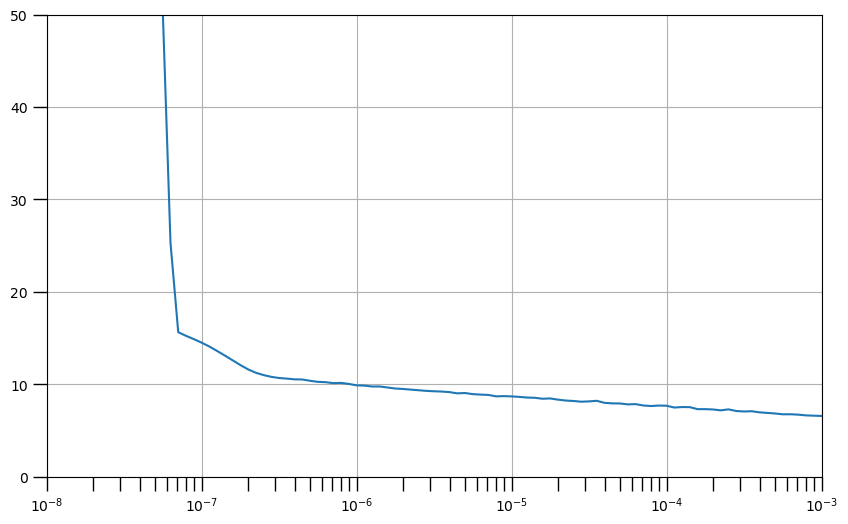

In [53]:
lrs=1e-8 *(10**(np.arange(200)/20))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lrs,history.history['loss'])
plt.tick_params('both',length=10,width=1,which='both')
plt.axis([1e-8,1e-3,0,50])

In [54]:
def model_forecast(model,series,window_size,batch_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda w:w.batch(window_size))
    dataset=dataset.batch(batch_size).prefetch(1)
    forecast=model.predict(dataset)
    return forecast

15/15 [==============================] - 0s 10ms/step


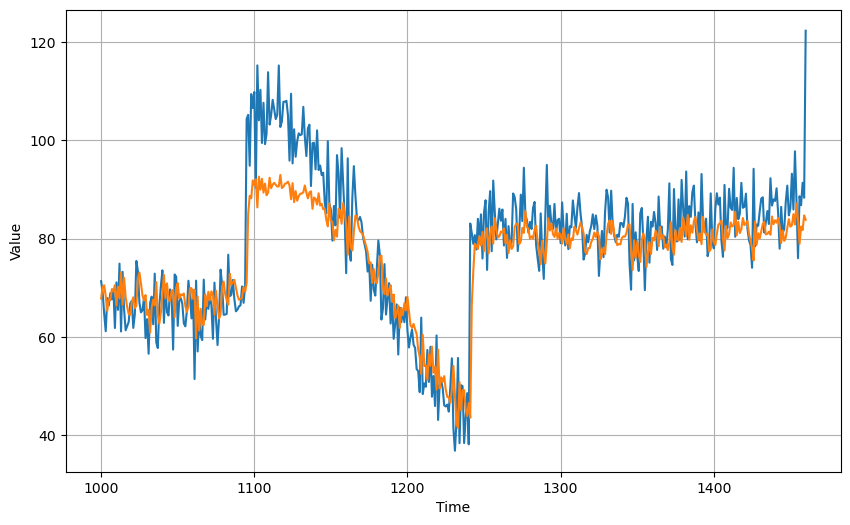

In [56]:
forecast_series=series[split_time-window_size:-1]
forecast=model_forecast(model_tune,forecast_series,window_size,batch_size)
results=forecast.squeeze()
plot_series(time_valid,(x_valid,results))

In [57]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

65.69961
5.9938817
